# **TIPE version 15 -2014**

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Le Dataset est disponible sur:
https://data.iledefrance.fr/explore/dataset/qualite-de-lair-mesuree-dans-la-station-auber/information/



In [3]:
from google.colab import files
uploaded = files.upload()

Saving qualite-de-lair-mesuree-dans-la-station-auber.csv to qualite-de-lair-mesuree-dans-la-station-auber.csv


# Traitement des données

In [4]:
df=pd.read_csv('qualite-de-lair-mesuree-dans-la-station-auber.csv',sep=';')
df=df[~df['DATE/HEURE'].isna()]
df['DATE/HEURE']=pd.to_datetime(df['DATE/HEURE'])

In [5]:
df['DATE/HEURE'].head()

0    2021-12-06 01:00:00+01:00
1    2021-12-06 00:00:00+01:00
2    2021-12-05 23:00:00+01:00
3    2021-12-05 22:00:00+01:00
4    2021-12-05 21:00:00+01:00
Name: DATE/HEURE, dtype: object

##Convertir la date de string en un une date exploitable

In [6]:
df['year']=df['DATE/HEURE'].apply(lambda x:int(str(x).split('-')[0]))
df['Date']=df['DATE/HEURE'].apply(lambda x:str(x).split(' ')[0])
df=df.replace({'ND':np.nan}) #enlever les ND pour mettre des nan à la place

## Pour le transformer en float (en Nan si on ne peut pas convertir)

In [7]:
def transform_to_float(value):
  try:
    float(value)
    return float(value)
  except ValueError:
    return 0

for col in ['NO','NO2','PM10','PM2.5','CO2','TEMP','HUMI']:
  df[col]=df[col].apply(lambda x:str(x).replace(',','.')) #remplace les virgules par des points pour avoir des floats corrects
  #col_int=df[col].apply(lambda x: can_be_transformed_float(x)) #regarde le nombre de valeurs convertibles
  #print('The percentage of Float in',col,'is',col_int.sum()/len(col_int))
  df[col]=df[col].apply(lambda x:transform_to_float(x)).astype('float')


##Nombre de données exploitables par an

,DATE/HEURE,NO,NO2,PM10,PM2.5,CO2,TEMP,HUMI,Date
year,,,,,,,,,
2013,0.0,0.186915,0.185659,0.039278,0.025919,0.081640,0.006166,0.005252,0.0
2014,0.0,0.076036,0.073753,0.023747,0.009476,0.055828,0.002055,0.001598,0.0
2015,0.0,0.094635,0.094064,0.013242,0.099658,0.060845,0.001826,0.001712,0.0
2016,0.0,0.028304,0.009929,0.018831,0.041771,0.016891,0.000000,0.000114,0.0
2017,0.0,0.015072,0.008906,0.021694,0.029916,0.151290,0.000913,0.001028,0.0
2018,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
2019,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
2020,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
2021,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


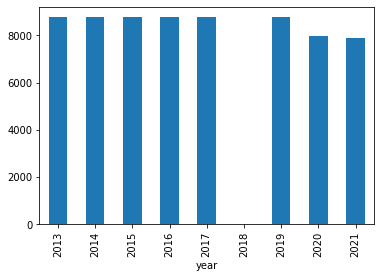

In [8]:
df.groupby('year').count()['DATE/HEURE'].plot.bar()
df.groupby('year').agg(lambda x: x.isna().sum())/df.fillna(0).groupby('year').count()

Cet histogramme permet de visualiser le nombre données par années.

In [9]:
df=df[df['year']==2014] #on prends les données de 2014
print('Number of nan per colums',
      df.isna().sum()/len(df))
df=df.fillna(df.mean()) #remplace les cases vides (Nan : not a number) par la moyenne de nos données

Number of nan per colums DATE/HEURE    0.000000
NO            0.076036
NO2           0.073753
PM10          0.023747
PM2.5         0.009476
CO2           0.055828
TEMP          0.002055
HUMI          0.001598
year          0.000000
Date          0.000000
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


Les données sont heures par heures nous allons plutot les entrainer jour par jour: on utilise donc groupby

In [10]:
df_daily=df.groupby('Date').mean()

## Création des features pour la prédiction

Pour prédire le PM2.5 nous prenons en compte uniquement les concentrations de la journée précédente et de celle encore avant. Pour cela on utilise shift(n) qui permet de décaler les données de n lignes.

In [11]:
y=df_daily['PM2.5'] #definition de la variable à prédire
df_daily['Y']=df_daily['PM2.5'] #definition de la variable à prédire

df_daily_t1=df_daily.shift() #utilisation d'un shift 1 pour avoir les données de la journée précédente
df_daily_t1.columns=df_daily.columns+'_t-1'
df_daily_t2=df_daily.shift(2)  #utilisation d'un shift 2 pour avoir les données de deux jour plus tôt
df_daily_t2.columns=df_daily.columns+'_t-2'
#concaténation dans un même DataFrame X
X = pd.concat([df_daily['Y'],df_daily_t1.drop('year_t-1',axis=1),df_daily_t2.drop('year_t-2',axis=1)], axis=1).iloc[2:,:]

X.drop(columns=['Y','Y_t-1','Y_t-2']) #n'a plus les deux premières lignes a cause des shifts on va donc les retirer à y

y.drop(index = y.index[0], axis=0, inplace=True)
y.drop(index = y.index[0], axis=0, inplace=True)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

## Visualisation des données

On va essayer de prédire dans cette version la concentration en PM2.5

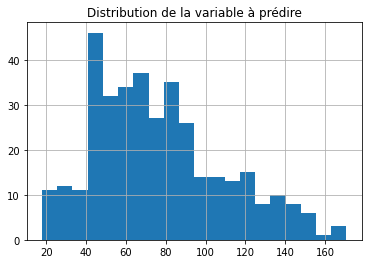

In [13]:
y.hist(bins=20)
plt.title('Distribution de la variable à prédire');

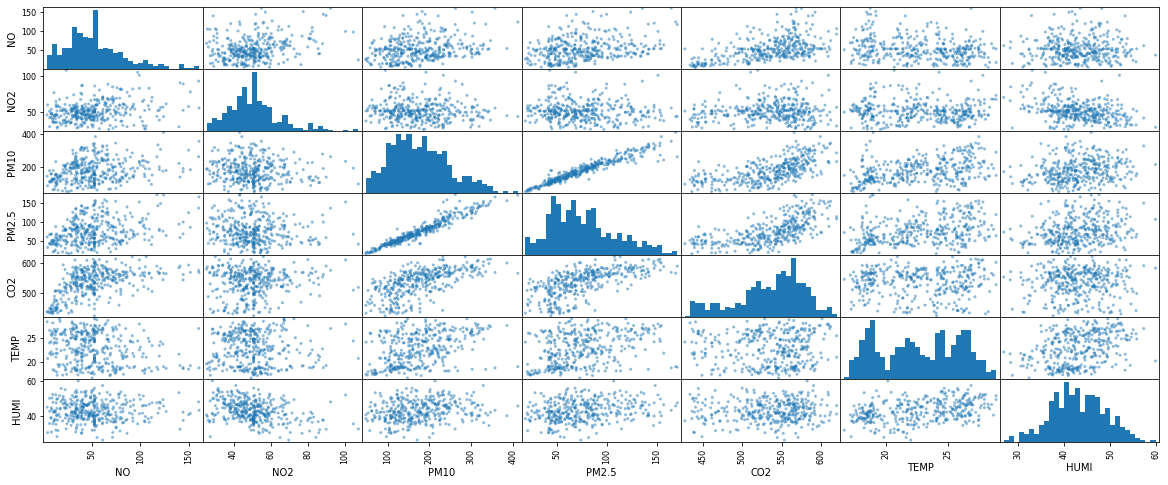

In [14]:
pd.plotting.scatter_matrix(df_daily.drop(['Y','year'],axis=1), hist_kwds={'bins':30}, figsize=(20, 8));

## Visualisation de la corrélation entre les données

On regarde la heatmap montrant les correlations

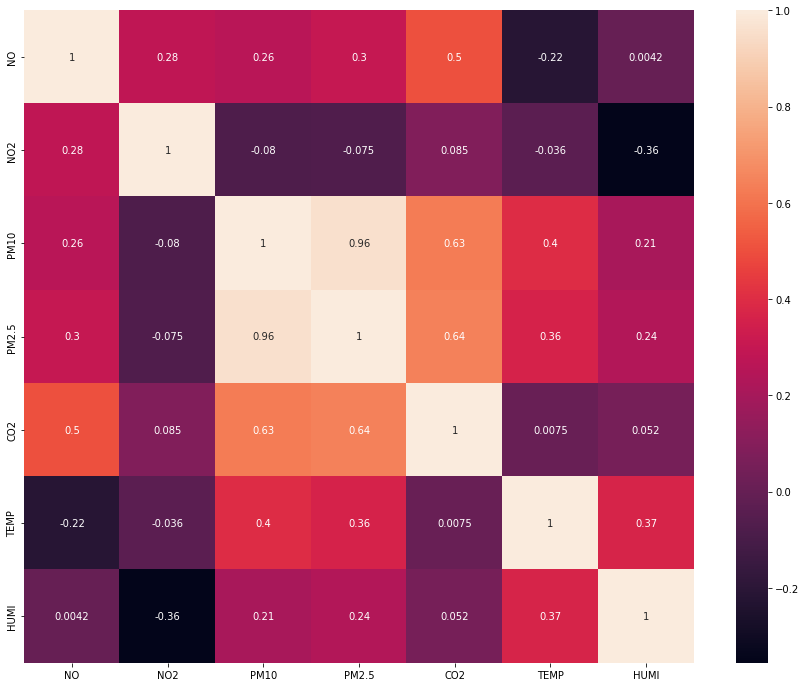

In [15]:
plt.figure(figsize=(15,12))
sns.heatmap(df_daily.drop(['year','Y'], axis=1).corr(),
        xticklabels=df_daily.drop(['year','Y'], axis=1).columns,
        yticklabels=df_daily.drop(['year','Y'], axis=1).columns,annot=True)

## Normalisation des données

Nous allons normaliser les données à l'aide de Standart Scaler:

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
train_scaler = StandardScaler().fit(X_train) #Normalisation en utilisant Standart Scaler
test_scaler  = StandardScaler().fit(X_test)

X_train = pd.DataFrame(train_scaler.transform(X_train))
X_test  = pd.DataFrame(test_scaler.transform(X_test))

In [18]:
print('Il y a',len(X_train),'elements dans le training set, et',len(X_test),'dans celui de testing')

Il y a 243 elements dans le training set, et 120 dans celui de testing


In [19]:
print(X_train.count())
print(X_test.count()) #on vérifie si on a des données pour tous les jours

0     243
1     243
2     243
3     243
4     243
5     243
6     243
7     243
8     243
9     243
10    243
11    243
12    243
13    243
14    243
15    243
16    243
dtype: int64
0     120
1     120
2     120
3     120
4     120
5     120
6     120
7     120
8     120
9     120
10    120
11    120
12    120
13    120
14    120
15    120
16    120
dtype: int64


#Prédiction

##Avec Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression().fit(X_train,y_train) #création d'une fonction adaptée à notre problème qui va permettre la prédiction

print('Le R2 sur le training set est',lr.score(X_train,y_train))
print('Le R2 sur le testing set est',lr.score(X_test,y_test))

Le R2 sur le training set est 1.0
Le R2 sur le testing set est 0.9822576165587582


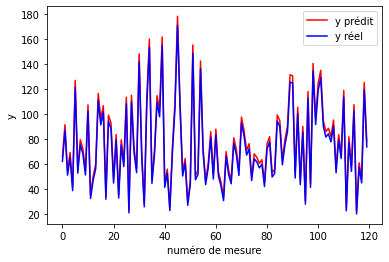

In [21]:
plt.plot(np.arange(len(y_test)),lr.predict(X_test),'r') #pour visualiser on va supperposer le yprédit et le yréel
plt.plot(np.arange(len(y_test)),y_test,'b')
plt.xlabel('numéro de mesure')
plt.ylabel('y')
plt.legend(['y prédit', 'y réel'])

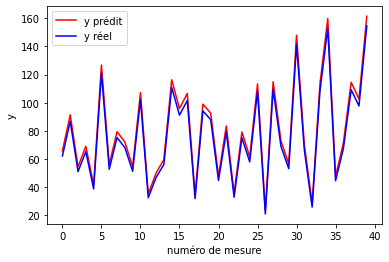

In [22]:
plt.plot(np.arange(len(y_test[:40])),lr.predict(X_test[:40]),'r') #pour plus de lisibilité on va visualiser seulement les 40 premières mesures
plt.plot(np.arange(len(y_test[:40])),y_test[:40],'b')
plt.xlabel('numéro de mesure')
plt.ylabel('y')
plt.legend(['y prédit', 'y réel'])

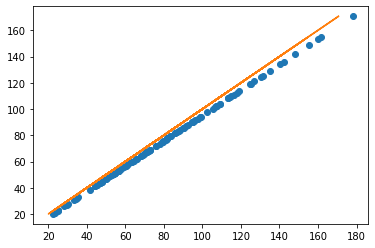

In [23]:
plt.plot(lr.predict(X_test),y_test,'o')
plt.plot(y_test,y_test)

##Avec RandomForest

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
rf=RandomForestRegressor().fit(X_train,y_train) #création d'une fonction rf adaptée au données

print('Le R2 sur le training set est',rf.score(X_train,y_train))
print('Le R2 sur le testing set est',rf.score(X_test,y_test))


Le R2 sur le training set est 0.999778473758794
Le R2 sur le testing set est 0.9813222828013919


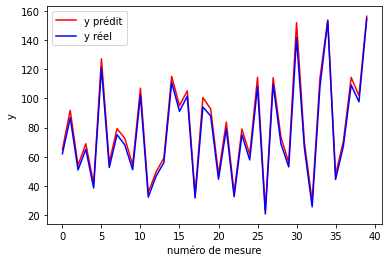

In [26]:
plt.plot(np.arange(len(y_test[:40])),rf.predict(X_test[:40]),'r') #on superpose le y prédit et le y réel pour visualiser
plt.plot(np.arange(len(y_test[:40])),y_test[:40],'b')
plt.xlabel('numéro de mesure')
plt.ylabel('y')
plt.legend(['y prédit', 'y réel'])

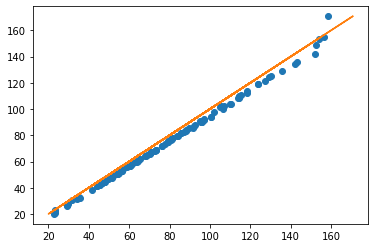

In [27]:
plt.plot(rf.predict(X_test),y_test,'o')
plt.plot(y_test,y_test)

##Gradiant boosted trees

In [28]:
import xgboost
reg_xgb = xgboost.XGBRegressor()
reg_xgb.fit(X_train,y_train, verbose=False)

[17:23:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [29]:
print('Le R2 sur le training set est',reg_xgb.score(X_train,y_train))
print('Le R2 sur le testing set est',reg_xgb.score(X_test,y_test))

Le R2 sur le training set est 0.9999596911245779
Le R2 sur le testing set est 0.9824788833129712


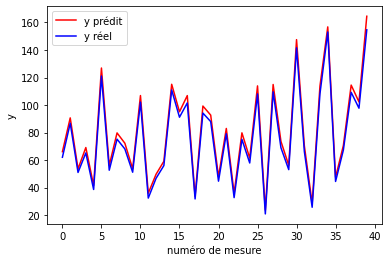

In [30]:
plt.plot(np.arange(len(y_test[:40])),reg_xgb.predict(X_test)[:40],'r')
plt.plot(np.arange(len(y_test[:40])),y_test[:40],'b')
plt.xlabel('numéro de mesure')
plt.ylabel('y')
plt.legend(['y prédit', 'y réel'])

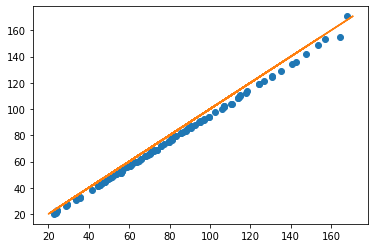

In [31]:
plt.plot(reg_xgb.predict(X_test),y_test,'o')
plt.plot(y_test,y_test)

##Randomized Search
Essayons d'optimiser les parametres de RF avec RandomizedSearchCV:

In [32]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
max_features = ['auto', 'sqrt']
# Nombre maximal de niveau dans l'arbre
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Nombre minimal de samples pour diviser un noeud 
min_samples_split = [2, 5, 10]
# Nombre minimal de sample necessaire a chaque noeud de feuille
min_samples_leaf = [1, 2, 4]
# Méthode de selection pour entrainer les samples pour entrainer chaque arbre
bootstrap = [True, False]
# Creation d'une grille aléatoire
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid, n_iter = 10, cv = 3, n_jobs = -1)
# Fit le modèle random search
rf_random.fit(X_train, y_train)
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2000}

In [33]:
print('Le R2 sur le training set est',rf_random.score(X_train,y_train))
print('Le R2 sur le testing set est',rf_random.score(X_test,y_test))

Le R2 sur le training set est 0.9998166660641129
Le R2 sur le testing set est 0.9813425767912469


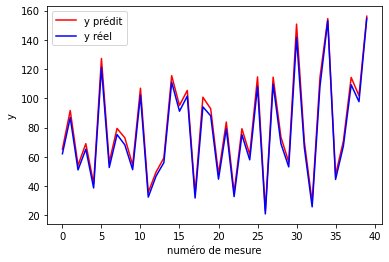

In [34]:
plt.plot(np.arange(len(y_test[:40])),rf_random.predict(X_test[:40]),'r')
plt.plot(np.arange(len(y_test[:40])),y_test[:40],'b')
plt.xlabel('numéro de mesure')
plt.ylabel('y')
plt.legend(['y prédit', 'y réel'])

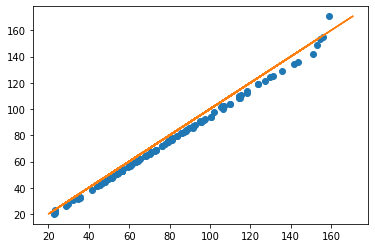

In [35]:
plt.plot(rf_random.predict(X_test),y_test,'o')
plt.plot(y_test,y_test)

##Essai avec un shift 7

On va essayere rajouter des données et de prendre en compte les données du même jour mais la semaine précédente. On va alors mettre un shift 7 en plus de ce qui avait déja était fait. 

In [36]:
y=df_daily['PM2.5'] #definition de la variable à prédire
df_daily['Y']=df_daily['PM2.5'] #definition de la variable à prédire

df_daily_t1=df_daily.shift() #utilisation d'un shift 1 pour avoir les données de la journée précédente
df_daily_t1.columns=df_daily.columns+'_t-1'
df_daily_t2=df_daily.shift(2)  #utilisation d'un shift 2 pour avoir les données de deux jour plus tôt
df_daily_t2.columns=df_daily.columns+'_t-2'
df_daily_t7=df_daily.shift(7)  #utilisation d'un shift 7 pour avoir les données de deux jour plus tôt
df_daily_t7.columns=df_daily.columns+'_t-7'

#concaténation dans un même DataFrame X
X = pd.concat([df_daily['Y'],df_daily_t1.drop('year_t-1',axis=1),df_daily_t2.drop('year_t-2',axis=1),df_daily_t7.drop('year_t-7',axis=1)], axis=1).iloc[2:,:]

X.drop(columns=['Y','Y_t-1','Y_t-2','Y_t-7']) #n'a plus les 7 premières lignes a cause des shifts on va donc les retirer à y

y.drop(index = y.index[:7], axis=0, inplace=True) #On doit enlever les 7 premières lignes a cause du shift
X.drop(index = X.index[:5], axis=0, inplace=True) 

In [37]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

train_scaler = StandardScaler().fit(X_train) #création d'un scaler pour normaliser
test_scaler  = StandardScaler().fit(X_test)

X_train = train_scaler.transform(X_train) #normalisation des données
X_test  = test_scaler.transform(X_test)

rf_2 = RandomForestRegressor().fit(X_train,y_train) #on va effectuer ce test avec RandomForest


In [38]:
print('Le R2 sur le training set est',rf_2.score(X_train,y_train))
print('Le R2 sur le testing set est',rf_2.score(X_test,y_test))

Le R2 sur le training set est 0.9997802364803344
Le R2 sur le testing set est 0.9803183250888362


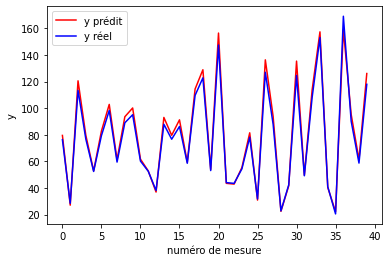

In [39]:
plt.plot(np.arange(len(y_test[:40])),rf_2.predict(X_test[:40]),'r') #visualisation comme précédemment
plt.plot(np.arange(len(y_test[:40])),y_test[:40],'b')
plt.xlabel('numéro de mesure')
plt.ylabel('y')
plt.legend(['y prédit', 'y réel'])

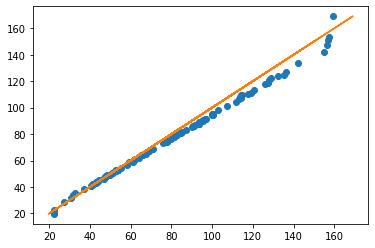

In [40]:
plt.plot(rf_2.predict(X_test),y_test,'o')
plt.plot(y_test,y_test)

## Annexe: méthode des moindres carrés

On cherche à estimer $y$ avec n données $(x_{1},x_{2},...,x_{n})$, soit trouver une relation $y=\sum_{k=1}^{n} β_{k}x_{k} +\beta_{0} $.










Où $β_{0},..., β_{n}$ sont les coefficients déterminés par la méthode et qui permettront de prédire Y.

On cherche à résoudre ce système et donc trouver β. On cherche à minimiser $\|  Y-Xβ \|$ c'est a dire à trouver β tel que $\|  Y-Xβ \|=d(Y,Im(X))$.



Où $Y=\begin{pmatrix}
  y_{1}\\ 
  \vdots\\
  y_{n}
\end{pmatrix}$
et $X=\begin{pmatrix}
  1 & x_{11} & \ldots & x_{1p}\\ 
  1 & x_{21} & \ldots & x_{2p}\\
  \vdots & \vdots & &  \vdots \\
  1 & x_{n1} & \ldots & x_{np}
\end{pmatrix}$ et 
$β=\begin{pmatrix}
  β_{0}\\ 
  \vdots\\
  \beta_{n}
\end{pmatrix}$

Notons $P$ le projecteur orthogonal sur $Im(X)$ alors $d(Y,Im(X))=\|  Y-PY \|$.

on a $Xβ=PY$ donc $^tX(Y-PY)=^tX(Y-Xβ)=0$ donc $^tXY=^tXXβ \:$ donc $β = (^tXX)^{-1}(^tXY) $